Importing all the necessary libraries

In [2]:
import pandas as pd

In [3]:
import pandas as pd
import numpy as np
import re  # used as a regular expression to find particular patterns and process it
import string  # used to obtain information in the string and manipulate the string overall
import warnings
import re
from wordcloud import WordCloud
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
# nltk
import nltk  # a natural language processing toolkit module associated in anaconda
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier


In [4]:
%matplotlib inline
warnings.filterwarnings('ignore')
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Loading the twitter dataset

In [6]:
DATASET_COLUMNS = ['target', 'ids', 'date', 'query', 'user', 'text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head(10)



,target,ids,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [7]:
#checking the nul value counts
np.sum (df.isnull().any(axis = 1))

0

In [8]:
#Obtaining the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   query   1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


positive reviews were initially marked as 4 we now want to change them to 1 (1.e. set positive reviews to and negative reviews as 0)

In [9]:
df["target"] = df["target"].replace(4,1)

now let us visualize the distribution of the target variables

Negative    800000
Positive    800000
Name: target, dtype: int64


Text(0.5, 1.0, 'Distribution of target variables')

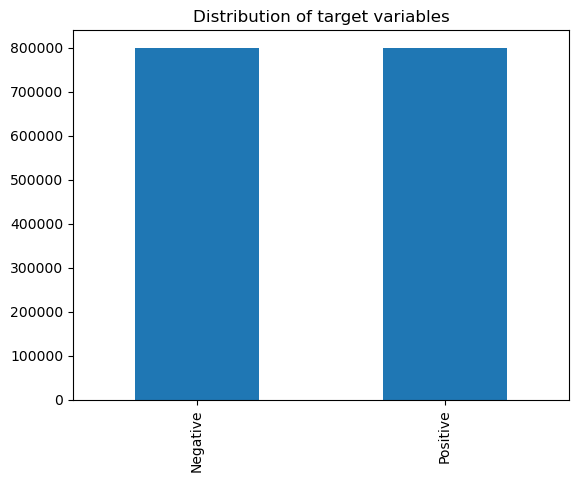

In [11]:
sentiment = {1: "Positive", 0: "Negative"}
print(df.target.apply(lambda x: sentiment [x]). value_counts())
df.target.apply(lambda x: sentiment [x]).value_counts().plot(kind = 'bar')
plt.title("Distribution of target variables")


Now the goal is to find a sentiment of the text based on the tweet, and so for this; only target and text are enough. So we create a new dataframe with the two features only.

In [12]:
data = df[["text", "target"]]
data.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


to fasten our analysis, we would like to select a subset of the 1.6million tweets.
in  this case we are going to use just 50000 tweets
so we sample out the 50k tweets. we are also keen to to maintain the correct target ratio

In [13]:
data_positive = data[data["target"] == 1]
data_negative = data[data["target"] == 0]
data_positive = data_positive.iloc[:int(25000)]
data_negative = data_negative.iloc[:int(25000)]
dataset = pd.concat([data_negative, data_positive])
print(len(dataset))
dataset.head()

50000


,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


Now we go to the next step of pre-processing the text data

and first, we convert to  lower case

In [14]:
dataset['text'] = dataset['text'].str.lower()
dataset['text'].head()

0    @switchfoot http://twitpic.com/2y1zl - awww, t...
1    is upset that he can't update his facebook by ...
2    @kenichan i dived many times for the ball. man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: text, dtype: object

REMOVING STOP WORDS
stop word handling is the process of indetifying and removing stopwords from text data before analyzing them.

stopwords are words that are common in a language and therefore do not contribute much to the meaning of a sentence. these words may nit really help in determining the sentiment of the text

therefore, it is good practice to remove stopwords from the text data before performing sentiment analysis.

by removing stopwords, the sentiment analysis algorithm can focus on the more meaningful words in the text, which can improve the accuracy of sentiment analysis result

In [15]:
#defining stopwords

stopwordslist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [17]:
#Removing stopwords

stopwords = set(stopwordslist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords ])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

0    @switchfoot http://twitpic.com/2y1zl - awww, t...
1    upset can't update facebook texting it... migh...
2    @kenichan dived many times ball. managed save ...
3                     whole body feels itchy like fire
4    @nationwideclass no, it's not behaving all. i'...
Name: text, dtype: object

tokenization is the process of breaking down a text into smaller units called tokens. in   NLP a tokenis  asequence of characters that represents a meaningful unit of information, such as word, punctuation mark or a number



The most common type of tokenization is word tokenization, which involves splitting a text into individual words. However, tokenization can also involve breaking a text down into sentences, phrases, or even characters, depending on the specific application.

Tokenization is an important step in many NLP tasks, as it enables the computer to work with text data in a more structured and meaningful way. For example, in sentiment analysis, tokenization can be used to extract individual words from a text and analyze their sentiment individually, which can provide more accurate results than analyzing the entire text as a whole.

In Python, there are several libraries that provide built-in support for text tokenization, such as NLTK, spaCy, and TextBlob. These libraries typically offer a variety of tokenization methods and can be customized to suit specific text processing needs.

In [30]:
#removing stopwords using nltk library

#tokenization of text
from nltk.corpus import stopwords
tokenizer = ToktokTokenizer()

#setting English stopwords

stopword_list = nltk.corpus.stopwords.words('english')

#removing standard english stopwords like prepositions, adverbs, etc
stop = set(stopwords.words('english'))
print("NLTK stop word lists \n")
print(stop)


#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwordslist]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwordslist]
    filtered_text = ''.join(filtered_tokens)
    return filtered_text

NLTK stop word lists 

{'we', 'any', 'didn', "wasn't", 'because', 'mustn', 'only', 'them', 'him', "you'll", "that'll", 'very', 'our', 's', 'its', 'it', 'ma', 'doing', 'with', 'at', 'they', "haven't", "you've", 'both', 'while', 're', 'wasn', "shan't", "hasn't", 'yourselves', 'again', 'me', 'won', "you'd", 'until', 'no', 'yours', "she's", 'themselves', 'through', 'few', 'll', 'between', 'each', 'so', 'whom', 'own', "should've", 'their', "mightn't", 'of', 'same', 'hasn', 'being', 'over', "won't", 'about', 'ain', 'a', 'how', "mustn't", 'has', 'and', "wouldn't", 'mightn', 'after', 'above', 'nor', 't', 'don', 've', "couldn't", 'before', 'these', 'does', 'needn', 'be', 'is', 'off', 'on', 'where', 'shouldn', "hadn't", 'if', "needn't", 'below', 'who', 'but', 'just', 'himself', 'his', 'why', 'to', 'than', 'been', 'y', 'here', 'into', 'as', 'by', 'most', 'when', 'myself', "didn't", 'she', 'my', "doesn't", 'yourself', 'o', 'ours', 'hadn', "don't", 'you', 'your', 'which', 'do', 'were', 'am', 'all',

In [32]:
dataset['text'] = dataset['text'].apply(remove_stopwords)
dataset['text'].tail()

824995                            yup.goingsleep.nightguys.
824996    @msunitedstatesthank,,,muchsupportingustonight...
824997    @tommcflyheytom?http://twitpic.com/3eumvcommen...
824998    teasingmack1-0takingvegasstormanothernighttrou...
824999                       @monicachunglovename!haha'mine
Name: text, dtype: object

##REMOVING URLs and NUMBERS

In [33]:
#removing urls
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))','',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].head()

0           @switchfootshouldagotdavidcarrthirddayit.;
1    upset'updatefacebooktexting...mightcryresultsc...
2    @kenichandivedmanytimesball.managedsave50%rest...
3                          wholebodyfeelsitchylikefire
4            @nationwideclass,'behavingall.'mad.?'see.
Name: text, dtype: object

In [34]:
#removing numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+','',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].head()

0           @switchfootshouldagotdavidcarrthirddayit.;
1    upset'updatefacebooktexting...mightcryresultsc...
2    @kenichandivedmanytimesball.managedsave%restgo...
3                          wholebodyfeelsitchylikefire
4            @nationwideclass,'behavingall.'mad.?'see.
Name: text, dtype: object

REMOVING CERTAIN PATTERNS

In [35]:
# remove patterns in the input text function
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt


In [36]:
#removing twitter handles (@usernames)
dataset['text'] = np.vectorize(remove_pattern)(dataset['text'], "@[\w]*")
dataset.head()


,text,target
0,.;,0
1,upset'updatefacebooktexting...mightcryresultsc...,0
2,.managedsave%restgobounds,0
3,wholebodyfeelsitchylikefire,0
4,",'behavingall.'mad.?'see.",0


In [37]:
# remove special characters, numbers and punctuations

dataset['text'] = dataset['text'].str.replace("[^a-zA-Z#]", " ")
dataset.head()


,text,target
0,,0
1,upset updatefacebooktexting mightcryresultsc...,0
2,managedsave restgobounds,0
3,wholebodyfeelsitchylikefire,0
4,behavingall mad see,0


In [38]:
# remove short words

dataset['text'] = dataset['text'].apply(
    lambda x: " ".join([w for w in x.split() if len(w) > 3]))
dataset.head()


,text,target
0,,0
1,upset updatefacebooktexting mightcryresultscho...,0
2,managedsave restgobounds,0
3,wholebodyfeelsitchylikefire,0
4,behavingall,0


Tokenizing the text

In [39]:
# Tokenizing the text

tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()


0                                                   []
1    [upset, updatefacebooktexting, mightcryresults...
2                          [managedsave, restgobounds]
3                        [wholebodyfeelsitchylikefire]
4                                        [behavingall]
Name: text, dtype: object

STEMMING


Stemming is the process of reducing a word to its base or root form, known as a stem, by removing any prefixes or suffixes. The goal of stemming is to reduce inflected or derived words to a common base form, which can help to improve the accuracy and efficiency of natural language processing (NLP) tasks such as text classification, information retrieval, and sentiment analysis.

For example, the stem of the word "running" is "run", and the stem of the word "played" is "play". By reducing all variations of a word to a common stem, stemming can help to group together words that have the same meaning, which can be useful for many NLP applications.

There are several algorithms for stemming in NLP, including the Porter stemming algorithm, Snowball stemming algorithm, and Lancaster stemming algorithm. Each algorithm has its own set of rules for removing prefixes and suffixes to generate the stem of a word.

In [40]:
# Applying Stemming

st = nltk.PorterStemmer()


def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data


dataset['text'] = dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()


0                                                   []
1    [upset, updatefacebooktexting, mightcryresults...
2                          [managedsave, restgobounds]
3                        [wholebodyfeelsitchylikefire]
4                                        [behavingall]
Name: text, dtype: object

LEMMATIZATION


Lemmatization is the process of reducing a word to its base or dictionary form, known as a lemma. Unlike stemming, which simply removes prefixes and suffixes to generate a root form of a word, lemmatization takes into account the context of the word and its part of speech, and produces a meaningful base form of the word.

For example, the lemma of the word "went" is "go", and the lemma of the word "better" can be "good" or "well" depending on the context. By reducing words to their lemmas, we can ensure that we are using the correct base form of a word, which can help to improve the accuracy of natural language processing tasks.

Lemmatization is a more sophisticated process than stemming and can be computationally more expensive, but it can be more accurate in producing meaningful word forms.

In Python, there are several libraries that provide built-in support for lemmatization, such as NLTK and spaCy. These libraries offer a variety of lemmatization algorithms and can be used to preprocess text data before applying NLP techniques such as sentiment analysis or topic modeling.



In [42]:
# Applying Lemmatization

nltk.download('wordnet')
nltk.download('omw-1.4')
lm = nltk.WordNetLemmatizer()


def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return ' ' .join(text)


dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset.head()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...


,text,target
0,,0
1,upset updatefacebooktexting mightcryresultscho...,0
2,managedsave restgobounds,0
3,wholebodyfeelsitchylikefire,0
4,behavingall,0


Exploratory Data Analysis using Wordcloud

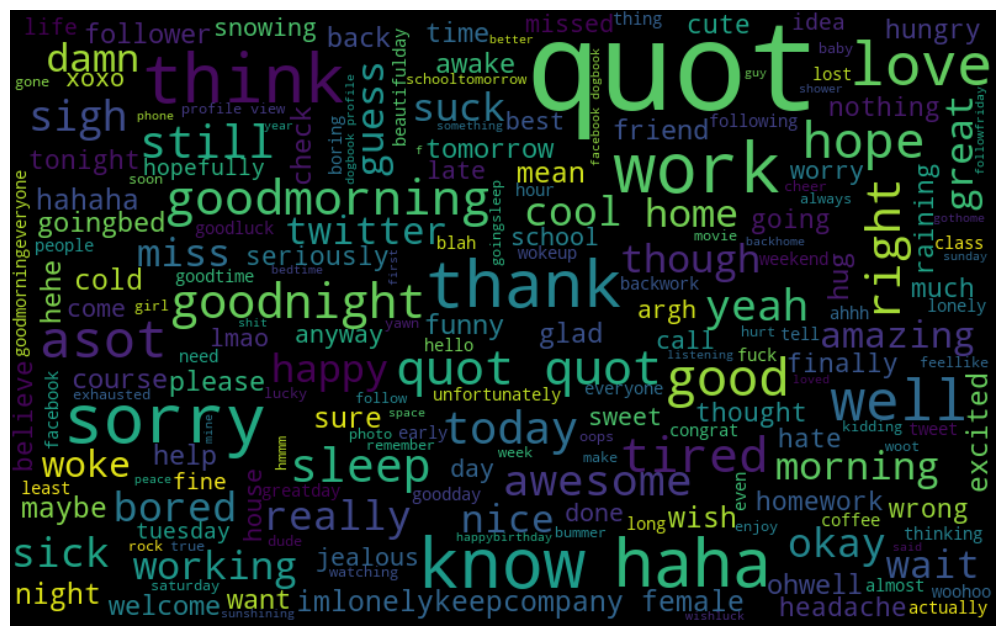

In [43]:
#Visualizing the frequent words
all_words = " ".join([sentence for sentence in dataset['text']])

wordcloud = WordCloud(width=800, height=500, random_state=42,
                      max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


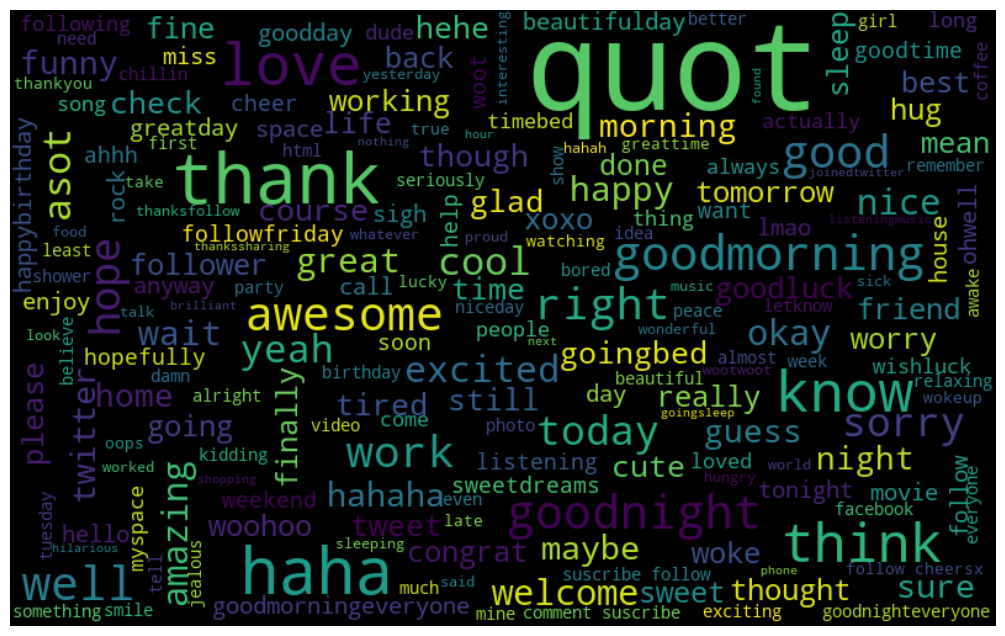

In [44]:
#frequent words visualization for positive

all_words = " ".join(
    [sentence for sentence in dataset['text'][dataset['target'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=42,
                      max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


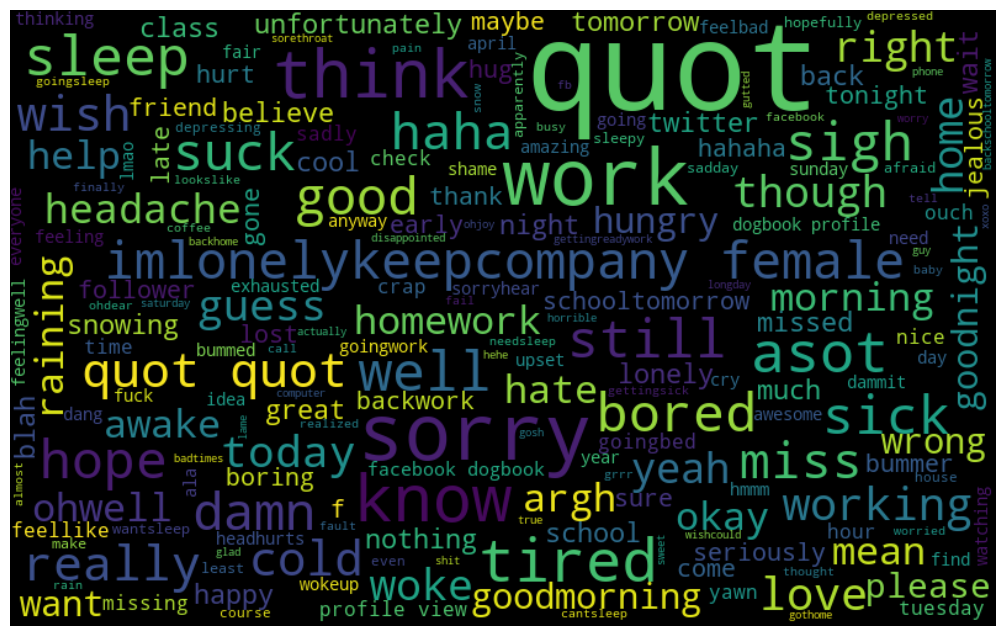

In [45]:
# frequent words visualization for negative

all_words = " ".join([sentence for sentence in dataset['text'][dataset['target']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#MODEL BUILDING

Data Preparation for Modelling


In [49]:
#input feature and label
X = dataset.text
y = dataset.target


In [50]:
#Spliting the data into train and test
X_train,X_val,y_train,y_val = train_test_split(X, y, test_size = 0.25, random_state = 42)

DATA VECTORIZING

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.90, min_df=0.02, max_features=1000, stop_words='english')

tfidf.fit(list(X_train) + list(X_val))
X_train_tfidf = tfidf.transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

In [52]:
# Count Vector approach (Bag of words approach)
# PS: We are not building any models using this approach as we are doing with Tf-IDF.

from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer(max_df=0.90, min_df=2,
                            max_features=1000, stop_words='english')
count_vec.fit(list(X_train) + list(X_val))

X_train_count_vec = count_vec.transform(X_train)
X_val_count_vec = count_vec.transform(X_val)


In [54]:
scores_dict_tfid = {}


{}

NAIVE BAYES: MODEL BUILDING

In [57]:
# Naive bayes using Tf-idf features

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_val_tfidf)
print('naive bayes tfidf accuracy %s' % accuracy_score(y_pred_nb, y_val))


naive bayes tfidf accuracy 0.49952


In [58]:
scores_dict_tfid['Multinomial Naive Bayes(Tfid)'] = accuracy_score(
    y_pred_nb, y_val)


<AxesSubplot:>

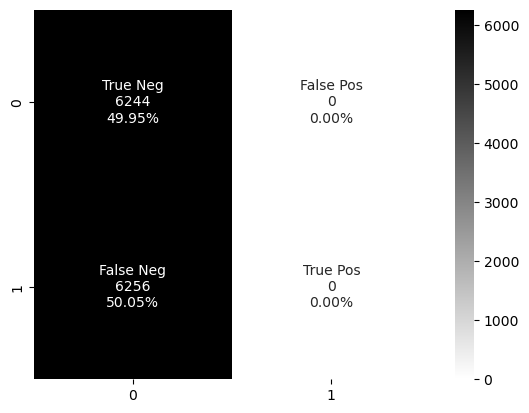

In [59]:
cf_matrix_model = confusion_matrix(y_val, y_pred_nb)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_model.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_model.flatten()/np.sum(cf_matrix_model)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix_model, annot=labels, fmt='', cmap='binary')


RANDOM FOREST : MODEL BUILDING

In [60]:
# Random Forest using Tf-idf features

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_val_tfidf)
print('Random forest tfidf accuracy %s' % accuracy_score(y_pred_rf, y_val))


Random forest tfidf accuracy 0.50696


In [61]:
scores_dict_tfid['Random Forest(tfid)'] = accuracy_score(y_pred_rf, y_val)


<AxesSubplot:>

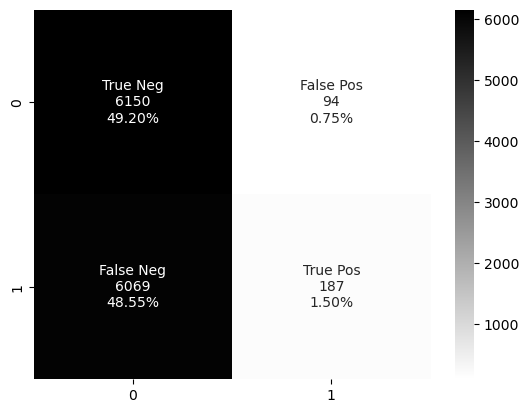

In [62]:
cf_matrix_model = confusion_matrix(y_val, y_pred_rf)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_model.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_model.flatten()/np.sum(cf_matrix_model)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix_model, annot=labels, fmt='', cmap='binary')


MODEL COMPARISON

In [63]:
# Random forest seems working well, but to get better result, we need to try with complete data and further analysis.

scores_dict_tfid


{'Multinomial Naive Bayes(Tfid)': 0.49952, 'Random Forest(tfid)': 0.50696}